# IDS ML Algorithm Using NSL-KDD Dataset

In [1]:
cd C:\\Users\\Sharuka Thirimanne\\Desktop\\FYP-ML-IDS

C:\Users\Sharuka Thirimanne\Desktop\FYP-ML-IDS


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from tensorflow.keras import Model, layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
scaler = MinMaxScaler()

c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def load_train_dataset():
    df_train = pd.read_csv('Datasets/csv_result-KDDTrain+.csv')
    df_train.drop(['id'], axis = 'columns' , inplace = True)
    
    df_train['class'] = df_train['class'].map( {'normal':0, 'anomaly':1} )
    
    limit = df_train.shape[1]-1
    
    X_train = df_train.iloc[:,0:limit]
    Y_train = df_train.iloc[:,limit]
    
    return X_train, Y_train, df_train

X_train, Y_train, df_train = load_train_dataset()

In [5]:
def load_test_dataset():
    df_test = pd.read_csv('Datasets/csv_result-KDDTest+.csv')
    df_test.drop(['id'], axis = 'columns' , inplace = True)
    
    df_test['class'] = df_test['class'].map( {'normal':0, 'anomaly':1} )
    
    limit = df_test.shape[1]-1
    
    X_test = df_test.iloc[:,0:limit]
    Y_test = df_test.iloc[:,limit]
    
    return X_test, Y_test, df_test

X_test, Y_test, df_test = load_test_dataset()

In [6]:
categorical_cols = ['protocol_type','flag','service']

In [37]:
df_train['service'].value_counts()[:10]

http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
other        4359
ecr_i        3077
telnet       2353
finger       1767
Name: service, dtype: int64

In [7]:
y = pd.DataFrame(Y_train)
y.groupby('class')['class'].count()

class
0    67343
1    58630
Name: class, dtype: int64

In [8]:
yy = pd.DataFrame(Y_test)
yy.groupby('class')['class'].count()

class
0     9711
1    12833
Name: class, dtype: int64

In [9]:
# Training dataset one hot encoding
ohe1 = OneHotEncoder(handle_unknown = 'ignore')
ohe1.fit(X_train[categorical_cols])
array_hot_encoded1 = ohe1.transform(X_train[categorical_cols]).toarray()
data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index)
X_train = X_train.drop(columns=categorical_cols)
X_train = pd.concat([data_hot_encoded1,X_train], axis=1)

In [10]:
# Test dataset one hot encoding
#ohe2 = OneHotEncoder(handle_unknown = 'ignore')
array_hot_encoded2 = ohe1.transform(X_test[categorical_cols]).toarray()
data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index)
X_test = X_test.drop(columns=categorical_cols)
X_test = pd.concat([data_hot_encoded2,X_test], axis=1)

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
X_train.mean()

-8.918362660338698e-19

In [12]:
X_test.shape

(22544, 122)

In [13]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [15]:
def neural_network():
    #Neural Network Model
    model = Sequential()
    model.add(Dense(128, input_dim=122, activation='relu',kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = METRICS)
    
    return model


In [17]:
estimator = KerasClassifier(build_fn=neural_network, epochs=20, batch_size=128, verbose=0)
print("Cross-Validation set accuracy: {:.6f} %".format((cross_val_score(estimator, X_train, Y_train, 
                                                                        cv=3,scoring='accuracy').mean())*100))

Cross-Validation set accuracy: 98.005922 %


In [18]:
estimator.fit(X_train,Y_train)

In [19]:
test_predictions = estimator.predict(X_test)
print("Train set accuracy           : {:.6f} %".format(estimator.score(X_train,Y_train)*100))
print("Test set accuracy            : {:.6f} %".format(accuracy_score(Y_test, test_predictions)*100))
print("Test set precision           : {:.8f} %".format(precision_score(Y_test, test_predictions)*100))
print("Test set recall              : {:.8f} %".format(recall_score(Y_test, test_predictions)*100))

Train set accuracy           : 97.843301 %
Test set accuracy            : 78.530873 %
Test set precision           : 92.58391050 %
Test set recall              : 67.70825216 %


In [20]:
def plot_metrics(history):
  metrics =  ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.8,1])
    elif metric == 'precision':
      plt.ylim([0.8,1])
    elif metric == 'recall':
      plt.ylim([0.8,1])

    plt.legend()

AttributeError: 'KerasClassifier' object has no attribute 'epoch'

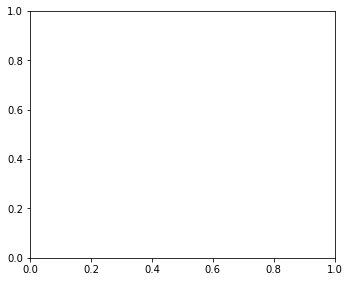

In [21]:
plot_metrics(estimator)

In [22]:
def plot_cm(labels, predictions, p=0.83):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives : ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives : ', cm[1][1])

True Negatives :  9015
False Positives:  696
False Negatives:  4144
True Positives :  8689


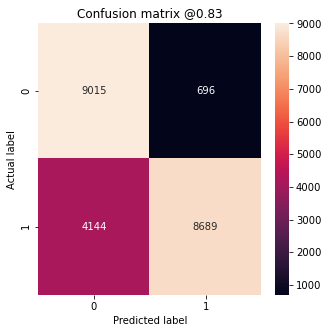

In [23]:
plot_cm(Y_test, test_predictions)

In [24]:
print(classification_report(Y_test, test_predictions.round()))

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      9711
           1       0.93      0.68      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.81      0.80      0.79     22544
weighted avg       0.82      0.79      0.78     22544

